# Exploratory Analysis of Stroke Risk Factors

#### Authors: Mateusz Mulka, Małgorzata Leszczyńska

### Objective:
The aim of this study is to conduct an exploratory analysis of a comprehensive dataset encompassing demographic and health-related features. The primary focus will be on understanding the factors that influence the risk of stroke.

### Dataset Description:  
The dataset contains a variety of variables including gender, age, hypertension, heart disease, marital status, residence type, work type, average glucose level, BMI, smoking status, and stroke (where 0 or 1 denotes absence or presence of a stroke).

### Dataset Link:
For reference, the dataset can be accessed via the following link: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

Libraries used in the project.

In [ ]:
!pip install dalex
!pip install shap

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from dalex import Explainer
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
from scipy.stats import chi2
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score
import shap

Importing the dataset.

In [ ]:
data = pd.read_excel('stroke_Big_data.xlsx')
data = data.iloc[:,0:]
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,17,1,0,No,children,Rural,61.67,37.0,Unknown,0
1,Male,38,1,0,Yes,Private,Rural,56.90,40.0,never smoked,0
2,Female,23,1,0,No,Private,Urban,70.03,31.0,smokes,0
3,Male,42,0,0,Yes,Private,Rural,210.48,34.0,never smoked,0
4,Female,53,0,0,Yes,Private,Rural,72.63,39.0,Unknown,0


Checking if there are non-available values in the dataset.

In [ ]:
data.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

Checking the data types.

In [ ]:
data.dtypes

gender                object
age                    int64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

Transforming data to data frame.

In [ ]:
df = pd.DataFrame(data)

Defining the code for the pivot tables and graphs.

In [ ]:
def create_merged_table(df, column):
    counts = df.groupby([column, 'stroke']).size().reset_index(name='count')

    total_counts = counts.groupby(column)['count'].transform('sum')

    counts['percentage'] = (counts['count'] / total_counts) * 100

    table_counts = counts.pivot(index=column, columns='stroke', values='count')
    table_counts.columns = ['Stroke=0 (count)', 'Stroke=1 (count)']

    table_percentages = counts.pivot(index=column, columns='stroke', values='percentage')
    table_percentages.columns = ['Stroke=0 (%)', 'Stroke=1 (%)']

    merged_table = pd.concat([table_counts, table_percentages], axis=1)
    merged_table.index.name = column.capitalize()
    return merged_table

In [ ]:
def draw_a_graph(df, column):
    counts = df.groupby([column, 'stroke']).size().reset_index(name='count')
    colors = {1: 'red', 0: 'blue'}
    name = column.capitalize()
    plt.figure(figsize=(8, 6))
    for index, row in counts.iterrows():
        plt.bar(row[column], row['count'], color=colors[row['stroke']], alpha=0.5)
        plt.text(row[column], row['count'] / 2, str(row['count']), ha='center', va='center')

    legend_handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in counts['stroke'].unique()]
    plt.legend(legend_handles, ['Stroke=1', 'Stroke=0'])

    plt.title(f'Bar Chart: {name} vs Stroke')
    plt.xlabel(f'{name}')
    plt.ylabel('Count')
    plt.show()

### Distribution of stroke cases among different genders.

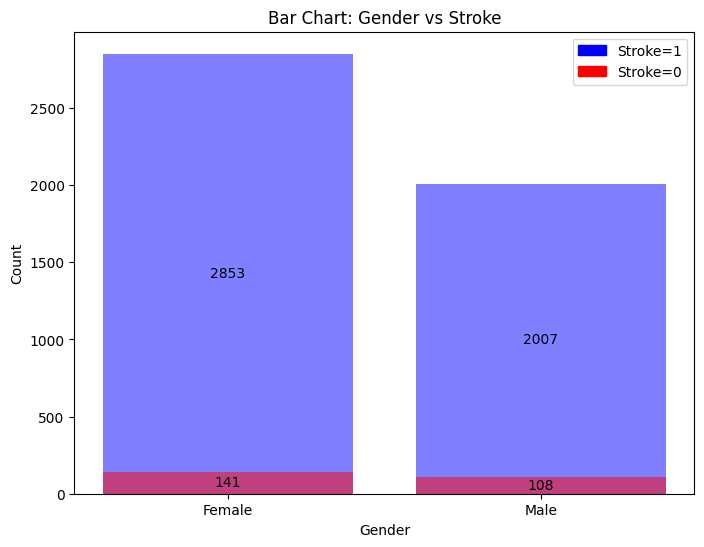

In [ ]:
draw_a_graph(df, 'gender')

In [ ]:
merged_table = create_merged_table(df, 'gender')
print(merged_table)

        Stroke=0 (count)  Stroke=1 (count)  Stroke=0 (%)  Stroke=1 (%)
Gender                                                                
Female              2853               141     95.290581      4.709419
Male                2007               108     94.893617      5.106383


On the chart above we can see that in the dataset there are more women than men, however the difference is not extremely big. Looking at the table, we can see that there is around 3000 women and 2100 men. What is important is the fact that procentage of women with stroke (4.7%) is similar to the procentage of men with stroke (5.1%).

However, in data analysis is not so obvious to claim that two similar looking values can be treated as equal. To check it, statistical test is being performed.

In [ ]:
def perform_chi_square_test(merged_table, v1, v2):
    v1_stroke_1_count = merged_table.loc[v1, 'Stroke=1 (count)']
    total_v1_count = merged_table.loc[v1].sum()

    v2_stroke_1_count = merged_table.loc[v2, 'Stroke=1 (count)']
    total_v2_count = merged_table.loc[v2].sum()

    # Creating the contingency table
    obs = np.array([[v1_stroke_1_count, total_v1_count - v1_stroke_1_count],
                    [v2_stroke_1_count, total_v2_count - v2_stroke_1_count]])

    # Performing the chi-square test
    chi2, p, _, _ = chi2_contingency(obs)

    # Displaying the test results
    print("Results of the chi-square test:")
    print("Chi-square value:", chi2)
    print("P-value:", p)

    # Interpreting the results
    alpha = 0.05
    if p < alpha:
        print("Differences in proportions are statistically significant.")
    else:
        print("There are no statistically significant differences in proportions.")

perform_chi_square_test(merged_table, 'Female', 'Male')

Results of the chi-square test:
Chi-square value: 0.2262451276978397
P-value: 0.6343220960031603
There are no statistically significant differences in proportions.


The results of the chi-square test shows that there is no significant difference in the precentage of stroke among genders.

### Correlation between age and the likelihood of experiencing a stroke.

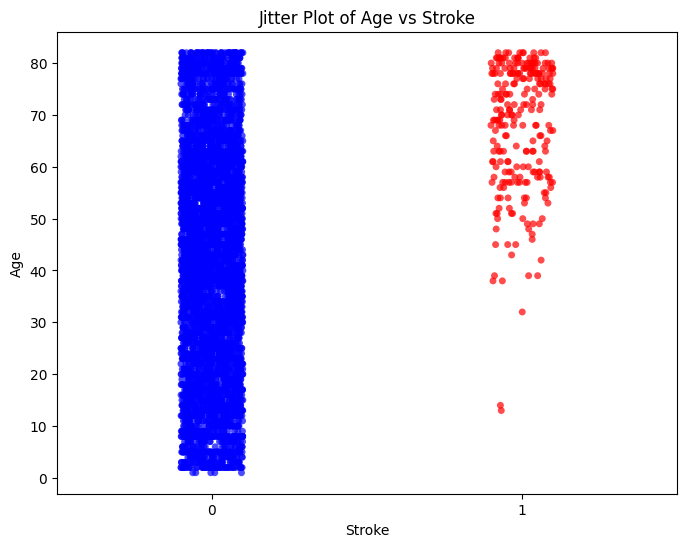

In [ ]:
colors = {0: 'blue', 1: 'red'}
plt.figure(figsize=(8, 6))
sns.stripplot(x="stroke", y="age", data=df, jitter=True, alpha=0.7, hue="stroke", palette=colors, legend=False)

plt.title('Jitter Plot of Age vs Stroke')
plt.xlabel('Stroke')
plt.ylabel('Age')
plt.show()

On the graph above the difference between the distribution of the stroke values can be observed. Firstly, in the group of people without the stroke, all age values appear. In the second group, with stroke, we can see that the observations are in the top of the chart, where the elderly people are. To show it more clearly, second chart has been printed.

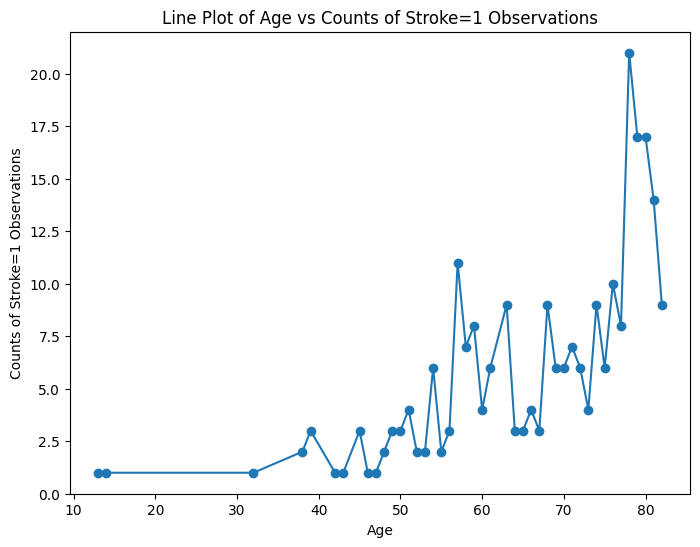

In [ ]:
stroke_1_df = df[df['stroke'] == 1]

age_counts = stroke_1_df.groupby('age').size().reset_index(name='count')

plt.figure(figsize=(8, 6))
plt.plot(age_counts['age'], age_counts['count'], marker='o', linestyle='-')

plt.title('Line Plot of Age vs Counts of Stroke=1 Observations')
plt.xlabel('Age')
plt.ylabel('Counts of Stroke=1 Observations')
plt.show()

This chart shows the appearance of stroke (counts) on different ages. It is simply to see that with the older age the greater the number of stroke apperance is. However, the correlation should be examine to determine, wheather we can say that the age and stroke apperance are correlated.

In [ ]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

age_bins = pd.cut(df['age'], bins=10)

contingency_table = pd.crosstab(age_bins, df['stroke'])

cramers_v_value = cramers_v(contingency_table.values)

print("Cramer's V value:", cramers_v_value)


Cramer's V value: 0.28516042382721235


To calculate the correlation using V-Cramer the "age_bins" has been used - the age from data set has been grouped into 10 bins to create the artificial variables to calculate the coefficient of correlation.

The final value is low enough to consider whether it is statistically significant. So, as the next step, the significance was tested.

In [ ]:
n = contingency_table.values.sum()

r, c = contingency_table.shape
degrees_of_freedom = min(r - 1, c - 1)

alpha = 0.05
critical_value = chi2.ppf(1 - alpha, degrees_of_freedom)

if cramers_v_value > np.sqrt(critical_value / n):
    print("Cramer's V value is statistically significant.")
else:
    print("Cramer's V value is not statistically significant.")

Cramer's V value is statistically significant.


As the result is saying, the coefficient of correlation is different from 0. That means that the correlation exists, however it is not very strong.

Nevertheless, as the graphs show, the stroke is more likely appear among older people.

### Difference in stroke prevalence between individuals with and without hypertension.

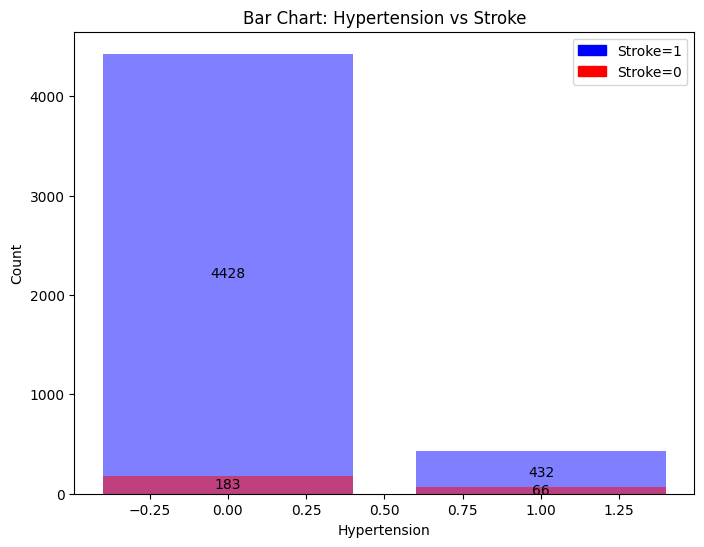

In [ ]:
draw_a_graph(df, 'hypertension')

In [ ]:
merged_table = create_merged_table(df, 'hypertension')
print(merged_table)

              Stroke=0 (count)  Stroke=1 (count)  Stroke=0 (%)  Stroke=1 (%)
Hypertension                                                                
0                         4428               183     96.031230      3.968770
1                          432                66     86.746988     13.253012


We can see that in the dataset there is much more of observation without the hypertension. Moreover, eventhough in the group of people without hypertension there is more people with a stroke (183) it is just around 4% of all people without the hypertension. Looking at the other site, to the people with hypertension, we can see that over 13% of them has a stroke.

Due to the visible difference in procentage the chi square test is not performed. Nevertheless, the correlation has been examined.

In [ ]:
contingency_table = pd.crosstab(df['hypertension'], df['stroke'])
cramers_v_value = cramers_v(contingency_table.values)
print("Cramer's V value:", cramers_v_value)

Cramer's V value: 0.12559408701862743


Suprisingly, the correlation is very low. Even if the correlation is statistically significant there is no visible influence on stroke.

### Impact of heart disease on stroke occurrence.

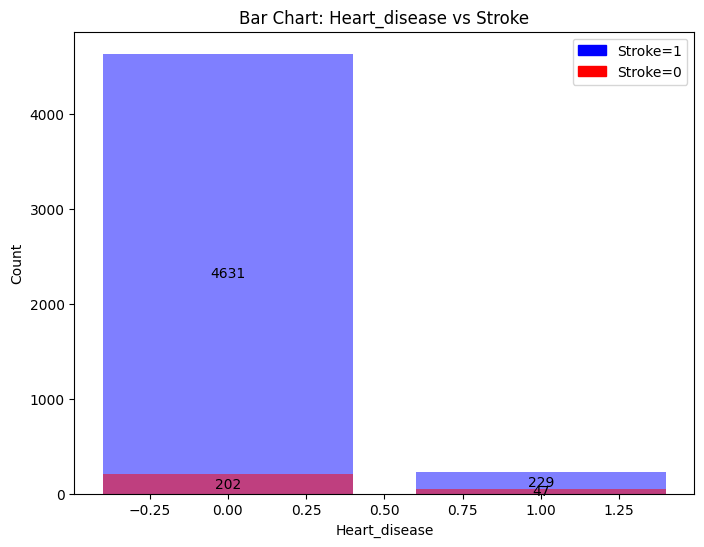

In [ ]:
draw_a_graph(df, 'heart_disease')

In [ ]:
merged_table = create_merged_table(df, 'heart_disease')
print(merged_table)

               Stroke=0 (count)  Stroke=1 (count)  Stroke=0 (%)  Stroke=1 (%)
Heart_disease                                                                
0                          4631               202     95.820401      4.179599
1                           229                47     82.971014     17.028986


 Analysing the next variable, occurence of heart disease, we can see that the situation is similar to the hypertension. Majority of people with stroke does not have a heartdisease (202), however the procentage of people with heart disease and with stroke is higher (17%) than without heart disease and with stroke (4%). Also, there is much more people without heart disease in general.

In [ ]:
contingency_table = pd.crosstab(df['heart_disease'], df['stroke'])
cramers_v_value = cramers_v(contingency_table.values)
print("Cramer's V value:", cramers_v_value)

Cramer's V value: 0.13216856146318726


The correlation is again very low.

### Role of marital status in stroke risk.

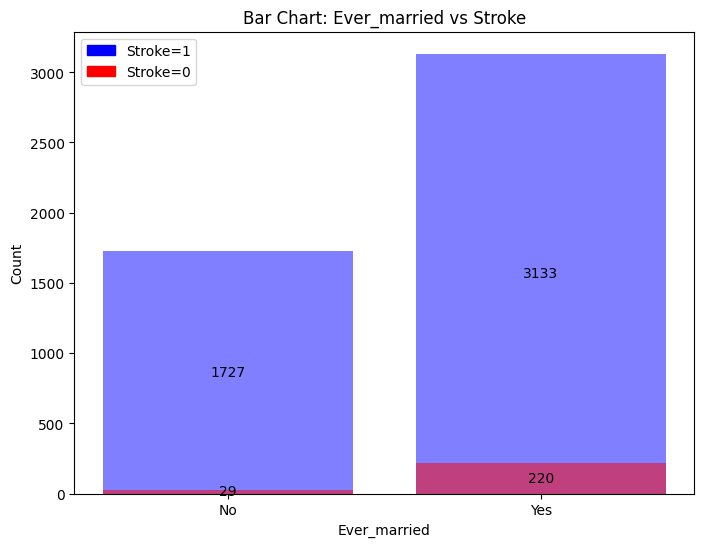

In [ ]:
draw_a_graph(df, 'ever_married')

In [ ]:
merged_table = create_merged_table(df, 'ever_married')
print(merged_table)

              Stroke=0 (count)  Stroke=1 (count)  Stroke=0 (%)  Stroke=1 (%)
Ever_married                                                                
No                        1727                29     98.348519      1.651481
Yes                       3133               220     93.438712      6.561288


In case of marriage, there is more people who have been married. Almost all the people with a stroke have been married (220 from 249 in total). Nevertheless, people with stroke are only 6.5% of all the married people.

In [ ]:
contingency_table = pd.crosstab(df['ever_married'], df['stroke'])
cramers_v_value = cramers_v(contingency_table.values)
print("Cramer's V value:", cramers_v_value)

Cramer's V value: 0.10643693254276906


One more time, the correlation is very low.

### Difference in stroke incidence between rural and urban residents.

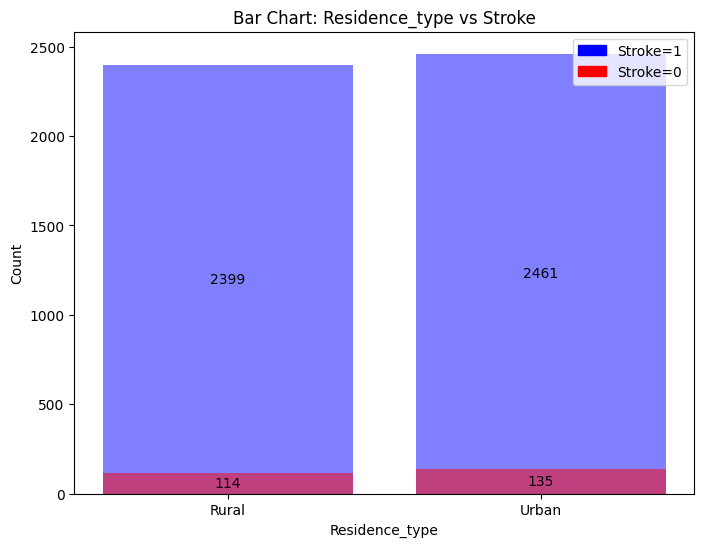

In [ ]:
draw_a_graph(df, 'Residence_type')

In [ ]:
merged_table = create_merged_table(df, 'Residence_type')
print(merged_table)

                Stroke=0 (count)  Stroke=1 (count)  Stroke=0 (%)  Stroke=1 (%)
Residence_type                                                                
Rural                       2399               114     95.463589      4.536411
Urban                       2461               135     94.799692      5.200308


Speaking about the Residence type it is not diffcult to see that the distribution of observation can be called equal. The test to check the equality of stroke occurance between the residence type was performed.

In [ ]:
perform_chi_square_test(merged_table, 'Rural', 'Urban')

Results of the chi-square test:
Chi-square value: 1.0934724816873607
P-value: 0.2957030979372469
There are no statistically significant differences in proportions.


Based on above test we can say that there is no statystical difference between the distribution of stroke occurance and residence type.

### Relationship between different types of employment and stroke risk.

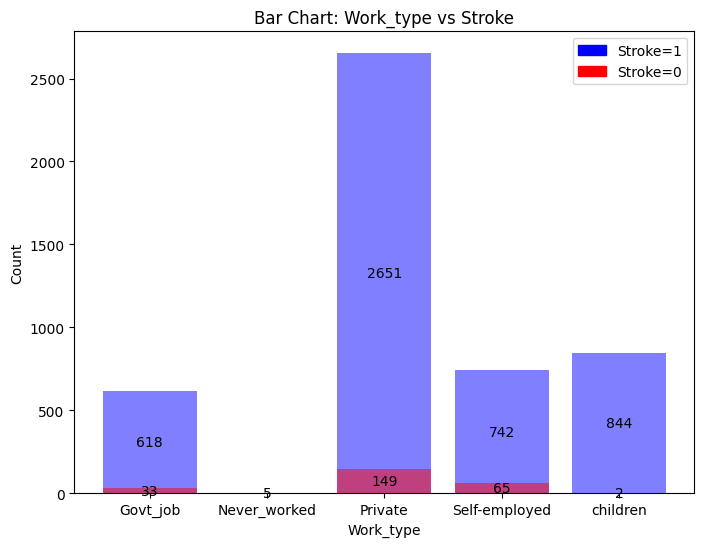

In [ ]:
draw_a_graph(df, 'work_type')

In [ ]:
merged_table = create_merged_table(df, 'work_type')
print(merged_table)

               Stroke=0 (count)  Stroke=1 (count)  Stroke=0 (%)  Stroke=1 (%)
Work_type                                                                    
Govt_job                  618.0              33.0     94.930876      5.069124
Never_worked                5.0               NaN    100.000000           NaN
Private                  2651.0             149.0     94.678571      5.321429
Self-employed             742.0              65.0     91.945477      8.054523
children                  844.0               2.0     99.763593      0.236407


With the work type is a little bit more interesting, because there is more than two options. Firstly, we can see that in the dataset the most popular work type is working in private sector. Next, with small differences there are goverment jobs and self-emplyment. In the data set there is almost 850 children. Lastly, there is only 5 people who has never worked. We can see that between working people precentage of people with stroke is between 5% and 8%. Among children there are only two cases of stroke and among people who have never worked - none, but the sample group is very little. The difference between precentage has been tested.

In [ ]:
perform_chi_square_test(merged_table, 'Private', 'Self-employed')

Results of the chi-square test:
Chi-square value: 4.9835227499821935
P-value: 0.02558982471048818
Differences in proportions are statistically significant.


In [ ]:
perform_chi_square_test(merged_table, 'Govt_job', 'Self-employed')

Results of the chi-square test:
Chi-square value: 5.19017036530974
P-value: 0.02271498940821206
Differences in proportions are statistically significant.


We can see that in these two examples - pair Private & Self-employed and pair Goverment jobs & Self-employed - the significant difference appear. Based on that, we can say that it is the most likely for stroke to occur if the person is self employed.

### Distribution of average glucose levels among individuals who have experienced a stroke.

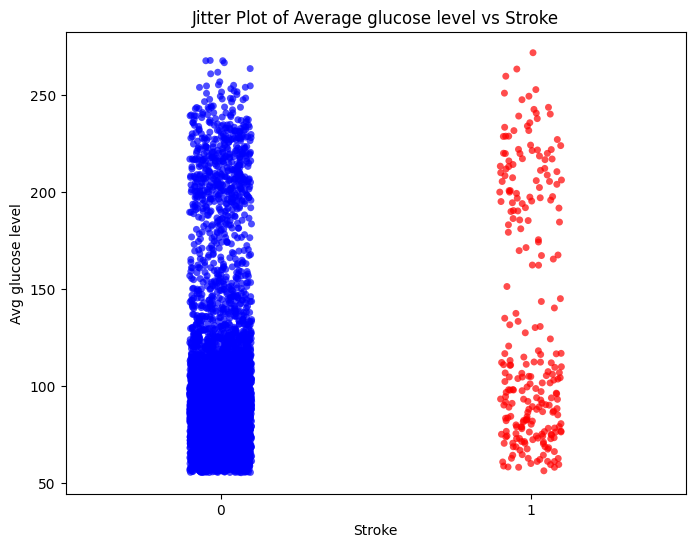

In [ ]:
colors = {0: 'blue', 1: 'red'}
plt.figure(figsize=(8, 6))
sns.stripplot(x="stroke", y="avg_glucose_level", data=df, jitter=True, alpha=0.7, hue="stroke", palette=colors, legend=False)

plt.title('Jitter Plot of Average glucose level vs Stroke')
plt.xlabel('Stroke')
plt.ylabel('Avg glucose level')
plt.show()

We can see on the above graph that people with a stroke appear equaly to those without a stroke. There is no significant and visible grouping of people with a stroke in the speific glucose level. Based on the graph there is no indication to examine the correlation or other coefficient.

### Correlation between BMI and stroke occurrence.

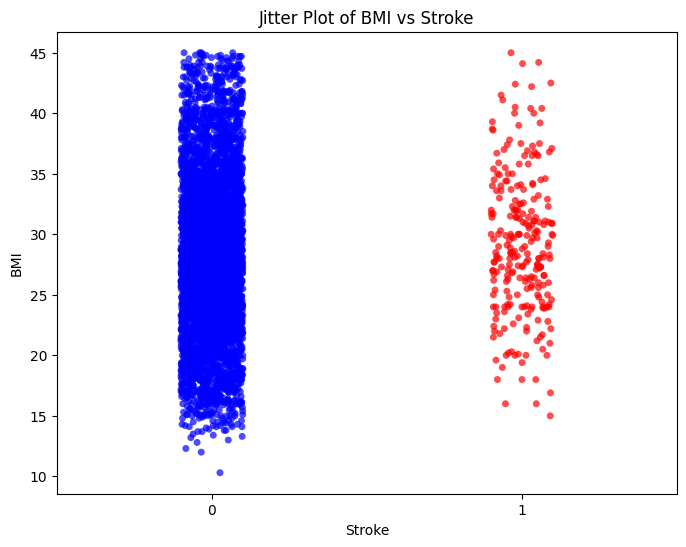

In [ ]:
colors = {0: 'blue', 1: 'red'}
plt.figure(figsize=(8, 6))
sns.stripplot(x="stroke", y="bmi", data=df, jitter=True, alpha=0.7, hue="stroke", palette=colors, legend=False)

plt.title('Jitter Plot of BMI vs Stroke')
plt.xlabel('Stroke')
plt.ylabel('BMI')
plt.show()

Similarly to the average glucose level, the graph shows that there is no visible grouping of stroke occurance in people with a specific BMI. There is no indication to examine the correlation.

### Influence of smoking status on the likelihood of having a stroke.

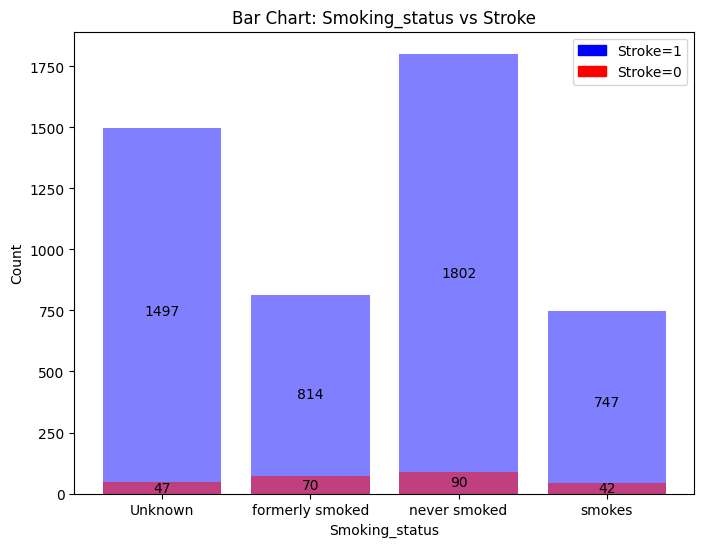

In [ ]:
draw_a_graph(df, 'smoking_status')

In [ ]:
merged_table = create_merged_table(df, 'smoking_status')
print(merged_table)

                 Stroke=0 (count)  Stroke=1 (count)  Stroke=0 (%)  \
Smoking_status                                                      
Unknown                      1497                47     96.955959   
formerly smoked               814                70     92.081448   
never smoked                 1802                90     95.243129   
smokes                        747                42     94.676806   

                 Stroke=1 (%)  
Smoking_status                 
Unknown              3.044041  
formerly smoked      7.918552  
never smoked         4.756871  
smokes               5.323194  


We can see that the representation of people who claim to never smoke and to those with unknown smoking status is similar. Additionaly, the number of people who formely smoke and those who smoke (regularly) is also similar. The procentage value of stroke occurance between the different smoking status is also very close to each other - it hestiates between 3% and 8%. As a next step the correlation was examined.

In [ ]:
contingency_table = pd.crosstab(df['smoking_status'], df['stroke'])
cramers_v_value = cramers_v(contingency_table.values)
print("Cramer's V value:", cramers_v_value)

Cramer's V value: 0.07165285008520017


As we see, the correlation is very low.

###  Significant correlations between pairs of variables indicating potential risk factors for stroke.

To calculate the correlation as a heat map, the transformation of the dataset was needed. All object variables were transformed into binary columns.

In [ ]:
data['gender'] = data['gender'].apply(lambda x : 1 if x == "Male" else 0)
data['ever_married'] = data['ever_married'].apply(lambda x : 1 if x == "Yes" else 0)
data['Residence_type'] = data['Residence_type'].apply(lambda x : 1 if x == "Urban" else 0)
column_transformer = make_column_transformer((OneHotEncoder(), ['work_type','smoking_status']),remainder='passthrough')
data = column_transformer.fit_transform(data)
data = pd.DataFrame(data=data, columns=column_transformer.get_feature_names_out())
data.head()

,onehotencoder__work_type_Govt_job,onehotencoder__work_type_Never_worked,onehotencoder__work_type_Private,onehotencoder__work_type_Self-employed,onehotencoder__work_type_children,onehotencoder__smoking_status_Unknown,onehotencoder__smoking_status_formerly smoked,onehotencoder__smoking_status_never smoked,onehotencoder__smoking_status_smokes,remainder__gender,remainder__age,remainder__hypertension,remainder__heart_disease,remainder__ever_married,remainder__Residence_type,remainder__avg_glucose_level,remainder__bmi,remainder__stroke
0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,17.0,1.0,0.0,0.0,0.0,61.67,37.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,38.0,1.0,0.0,1.0,0.0,56.90,40.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,23.0,1.0,0.0,0.0,1.0,70.03,31.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,42.0,0.0,0.0,1.0,0.0,210.48,34.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,53.0,0.0,0.0,1.0,0.0,72.63,39.0,0.0


Code for creating a heat map.

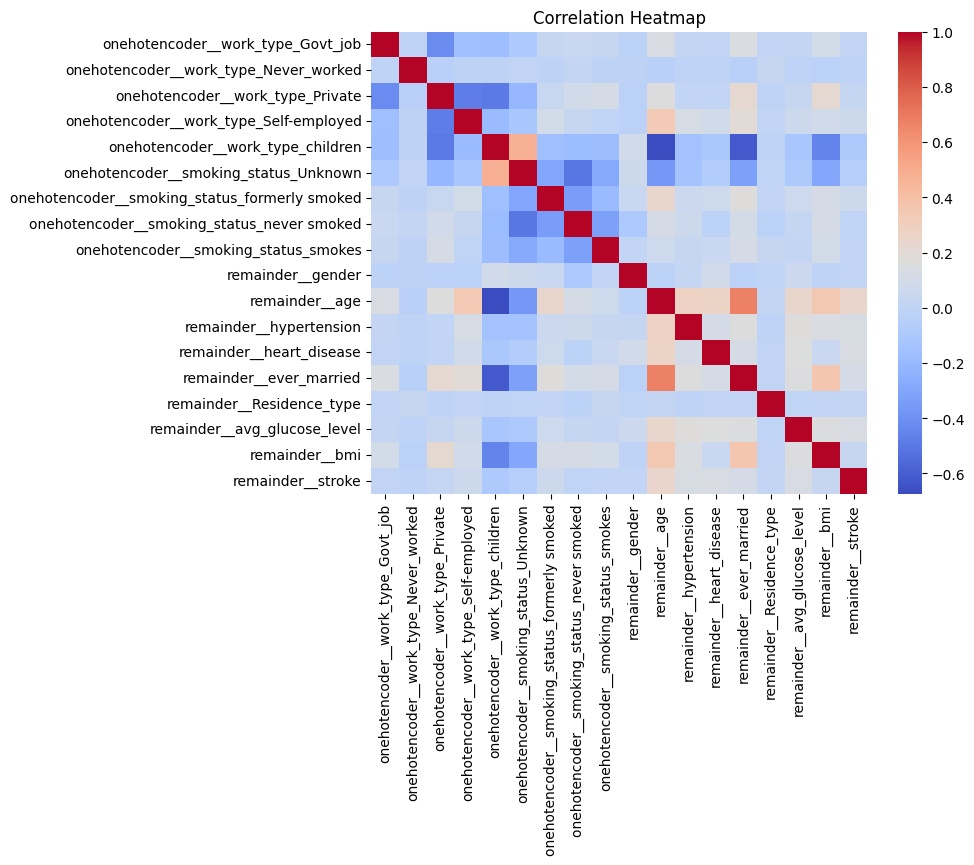

In [ ]:
def draw_heatmap(df):
    corr = df.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, cmap='coolwarm', annot=False)
    plt.title('Correlation Heatmap')
    plt.show()

draw_heatmap(data)

We can see that majority of a heat map is not correlated with each other. We can draw a coclusion that children are in a young age and was not married. We can also see that with being older, bmi increse. What is interesting is a fact that with marraige bmi also increase. Also, the older we get, the more likely we will be married. What is important in that graph is a fact that in any machine learning model there will be no one factor that is more intense due to correlation with another one.

## Prediction of stroke occurence based on demographic and health-related features.

In [ ]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,17,1,0,No,children,Rural,61.67,37.0,Unknown,0
1,Male,38,1,0,Yes,Private,Rural,56.90,40.0,never smoked,0
2,Female,23,1,0,No,Private,Urban,70.03,31.0,smokes,0
3,Male,42,0,0,Yes,Private,Rural,210.48,34.0,never smoked,0
4,Female,53,0,0,Yes,Private,Rural,72.63,39.0,Unknown,0


In [ ]:
categorical_columns = df.select_dtypes(include=['object']).columns

# One-Hot Encoding
encoded_data = pd.get_dummies(df, columns=categorical_columns)

encoded_data.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,17,1,0,61.67,37.0,0,False,True,True,False,...,False,False,False,True,True,False,True,False,False,False
1,38,1,0,56.90,40.0,0,False,True,False,True,...,False,True,False,False,True,False,False,False,True,False
2,23,1,0,70.03,31.0,0,True,False,True,False,...,False,True,False,False,False,True,False,False,False,True
3,42,0,0,210.48,34.0,0,False,True,False,True,...,False,True,False,False,True,False,False,False,True,False
4,53,0,0,72.63,39.0,0,True,False,False,True,...,False,True,False,False,True,False,True,False,False,False


In [ ]:
print(encoded_data['stroke'].value_counts())

stroke
0    4860
1     249
Name: count, dtype: int64


Choosing training and test data and applying undersampling and SMOTE for imbalanced dataframe

In [ ]:
def calculate_balance(data):
    balance = abs(data.value_counts(normalize=True)[0] - data.value_counts(normalize=True)[1])
    return balance

In [ ]:
# Performing undersampling once before the loop
undersampler = RandomUnderSampler(sampling_strategy={0: 3000}, random_state=0)
X_resampled, y_resampled = undersampler.fit_resample(encoded_data.drop('stroke', axis=1), encoded_data['stroke'])

num_seeds = 42
best_seed = None
best_balance_diff = float('inf')

for seed in range(num_seeds):
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=seed)

    balance_train = calculate_balance(y_train)
    balance_test = calculate_balance(y_test)
    balance_diff = abs(balance_train - balance_test)

    if balance_diff < best_balance_diff:
        best_balance_diff = balance_diff
        best_seed = seed

print(f"Best seed: {best_seed}, Best balance difference: {best_balance_diff}\n")

# Final data split for the best seed
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=best_seed)

# Applying SMOTE to the training set with a maximum of 500 values for class 1
#1400
smote = SMOTE(sampling_strategy={1: 500}, random_state=best_seed)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Display the number of 0s and 1s in the training set (for the best seed)
print(f"Number of observations in the training set (class 0): {y_train.value_counts()[0]}")
print(f"Number of observations in the training set (class 1): {y_train.value_counts()[1]}\n")

# Display the number of 0s and 1s in the training set after resampling
print(f"Number of observations in the training set (class 0): {y_train_resampled.value_counts()[0]}")
print(f"Number of observations in the training set (class 1): {y_train_resampled.value_counts()[1]}\n")

# Display the number of 0s and 1s in the test set (for the best seed)
print(f"Number of observations in the test set (class 0): {y_test.value_counts()[0]}")
print(f"Number of observations in the test set (class 1): {y_test.value_counts()[1]}")


Best seed: 2, Best balance difference: 0.0007103323763577585

Number of observations in the training set (class 0): 2400
Number of observations in the training set (class 1): 199

Number of observations in the training set (class 0): 2400
Number of observations in the training set (class 1): 500

Number of observations in the test set (class 0): 600
Number of observations in the test set (class 1): 50


In [ ]:
# Creating and fitting the logistic regression model with 'saga' solver
logistic_model = LogisticRegression(solver='saga', random_state=42, max_iter=10000)
logistic_model.fit(X_train_resampled, y_train_resampled)

# Predicting on the test set
y_pred = logistic_model.predict(X_test)

# Calculating accuracy and recall
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Recall:", recall)

Accuracy: 0.9184615384615384
Recall: 0.04


Despite that beforehand we did not decide to delete any columns, regarding such a small recall value it might be necessary. As we can see the variables that have the lowest correlation with 'stroke' value are

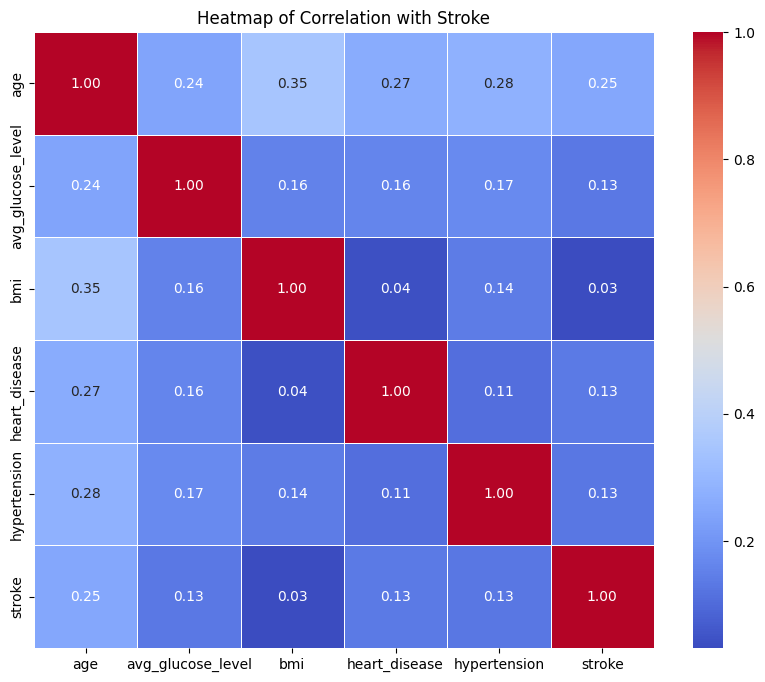

In [ ]:
# Selecting numeric columns (e.g., removing categorical columns)
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Adding the 'stroke' column to the numeric columns
columns_of_interest = numeric_columns.union(['stroke'])

# Creating a DataFrame containing the selected columns
selected_df = df[columns_of_interest]

# Calculating the correlation matrix
correlation_matrix = selected_df.corr()

# Creating a heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap of Correlation with Stroke')
plt.show()

In [ ]:
correlations = encoded_data.corr()['stroke'].drop('stroke')
print(correlations)

age                               0.247631
hypertension                      0.127891
heart_disease                     0.134905
avg_glucose_level                 0.131991
bmi                               0.031339
gender_Female                    -0.009081
gender_Male                       0.009081
ever_married_No                  -0.108299
ever_married_Yes                  0.108299
work_type_Govt_job                0.003467
work_type_Never_worked           -0.007085
work_type_Private                 0.022895
work_type_Self-employed           0.063981
work_type_children               -0.095943
Residence_type_Rural             -0.015415
Residence_type_Urban              0.015415
smoking_status_Unknown           -0.055924
smoking_status_formerly smoked    0.064683
smoking_status_never smoked      -0.004163
smoking_status_smokes             0.008920
Name: stroke, dtype: float64


After visualising correlation values once again in more relevant way for the model it becomes clear that deleting some of the columns might be benefitial. We have decided to delete columns with the lowest correlation rates and check various combinations of deleted columns, coming up with encoded_drop dataframe shown below.

In [ ]:
columns_to_drop = [
                    'smoking_status_Unknown','smoking_status_formerly smoked', 'smoking_status_never smoked','smoking_status_smokes'
                    ,'Residence_type_Rural','Residence_type_Urban'
                    ,'ever_married_No','ever_married_Yes'
                    ,'gender_Female','gender_Male'
                    ,'work_type_Govt_job','work_type_Never_worked','work_type_Private','work_type_Self-employed','work_type_children'
                   ]
encoded_drop = encoded_data.drop(columns_to_drop, axis=1)
encoded_drop.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,17,1,0,61.67,37.0,0
1,38,1,0,56.90,40.0,0
2,23,1,0,70.03,31.0,0
3,42,0,0,210.48,34.0,0
4,53,0,0,72.63,39.0,0


In [ ]:
# Performing undersampling once before the loop
undersampler = RandomUnderSampler(sampling_strategy={0: 1900}, random_state=0)
X_resampled, y_resampled = undersampler.fit_resample(encoded_drop.drop('stroke', axis=1), encoded_drop['stroke'])

num_seeds = 42
best_seed = None
best_balance_diff = float('inf')

for seed in range(num_seeds):
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=seed)

    balance_train = calculate_balance(y_train)
    balance_test = calculate_balance(y_test)
    balance_diff = abs(balance_train - balance_test)

    if balance_diff < best_balance_diff:
        best_balance_diff = balance_diff
        best_seed = seed

print(f"Best seed: {best_seed}, Best balance difference: {best_balance_diff}\n")

# Final data split for the best seed
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=best_seed)

# Applying SMOTE to the training set with a maximum of 1500 values for class 1
smote = SMOTE(sampling_strategy={1: 1500}, random_state=best_seed)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Display the number of 0s and 1s in the training set (for the best seed)
print(f"Number of observations in the training set (class 0): {y_train.value_counts()[0]}")
print(f"Number of observations in the training set (class 1): {y_train.value_counts()[1]}\n")

# Display the number of 0s and 1s in the training set after resampling
print(f"Number of observations in the training set (class 0): {y_train_resampled.value_counts()[0]}")
print(f"Number of observations in the training set (class 1): {y_train_resampled.value_counts()[1]}\n")

# Display the number of 0s and 1s in the test set (for the best seed)
print(f"Number of observations in the test set (class 0): {y_test.value_counts()[0]}")
print(f"Number of observations in the test set (class 1): {y_test.value_counts()[1]}")

# Creating and fitting the logistic regression model with 'saga' solver
logistic_model = LogisticRegression(solver='saga', random_state=42, max_iter=10000)
logistic_model.fit(X_train_resampled, y_train_resampled)

# Predicting on the test set
y_pred = logistic_model.predict(X_test)

# Calculating accuracy and recall
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Recall:", recall)


Best seed: 3, Best balance difference: 0.001028180256233302

Number of observations in the training set (class 0): 1520
Number of observations in the training set (class 1): 199

Number of observations in the training set (class 0): 1520
Number of observations in the training set (class 1): 1500

Number of observations in the test set (class 0): 380
Number of observations in the test set (class 1): 50
Accuracy: 0.7627906976744186
Recall: 0.7


After deleting desired columns and training our model once again we did manage to increase recall from 0.04 to 0.7 which is 17.5 times better result ! On the other hand it did affect precision that did decrease from around 0.92 to 0.76. This change is beneficial despite the change in accuracy as recall is the most important metric for medical data related models.

## Identification of the most important predictors of stroke risk according to the predictive model and contribution of SHAP values to interpreting the predictive model's decisions.

In [102]:
exp_lr = Explainer(logistic_model, X_train_resampled, y_train_resampled, label='Logistic regression')
obs = X_train_resampled.iloc[42, :]

# SHAP values
shap_values = exp_lr.predict_parts(obs, type='shap')
shap_values.plot()

# Break-down Plots for Interactions
bd1 = exp_lr.predict_parts(obs, type='break_down_interactions')

bd1.plot()

Preparation of a new explainer is initiated

  -> data              : 3020 rows 5 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 3020 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : Logistic regression
  -> predict function  : <function yhat_proba_default at 0x7cb7e9269a20> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0228, mean = 0.504, max = 0.952
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.952, mean = -0.00726, max = 0.964
  -> model_info        : package sklearn

A new explainer has been created!


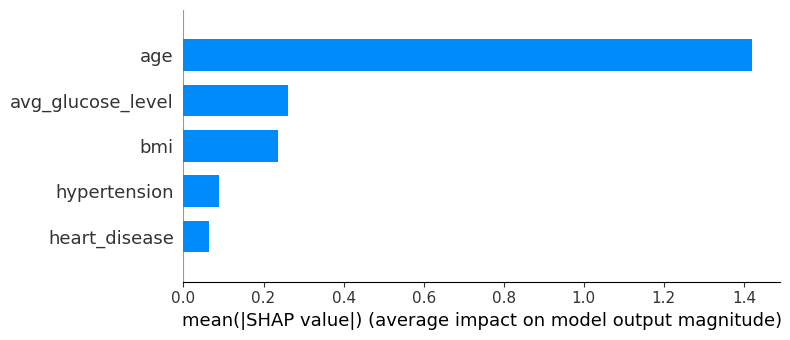

In [107]:
# Calculate SHAP values
explainer = shap.Explainer(logistic_model, X_train_resampled)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Force plot for a specific observation
#shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0, :])

## Identification of actionable insights or recommendations for stroke prevention based on analysis

Based on the average SHAP values we can draw conclusions that the most important factors regarding predicting heart stroke are age, average glucose level and bmi of the patient. Despite the fact that we can not control our age, we can still control our glucose level and bmi, those are the most important factors to be looking for.